In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Upload CSV file
scaled_data = pd.read_csv("Data/scaled_data.csv")

In [2]:
# List of variables according to group
Gender_Features = scaled_data.columns[1:2].tolist()
Baseline_Features = scaled_data.columns[2:23].tolist()
Time_Freq_Features = scaled_data.columns[23:34].tolist()
Vocal_Fold_Features = scaled_data.columns[34:56].tolist()
MFCC_Features = scaled_data.columns[56:140].tolist()
WT_FT_Features = scaled_data.columns[140:322].tolist()
TQWT_Features = scaled_data.columns[322:754].tolist()
Class = scaled_data.columns[754]

# Feature selection

In [3]:
X = scaled_data.iloc[:, 1:754]  # Features
y = scaled_data.iloc[:, 754]    # Class
grup = scaled_data["id"]        # Establish as indivisible group: subject id for CV

## mRMR

In [4]:
import mrmr

from mrmr import mrmr_classif
mrmr_features = mrmr_classif(X=X, y=y, K=20)


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 10.68it/s]


In [5]:
mrmr_X =pd.DataFrame(scaled_data[mrmr_features])
mrmr_data = pd.concat([scaled_data.iloc[:,:1], mrmr_X, scaled_data.iloc[:,754]], axis=1)

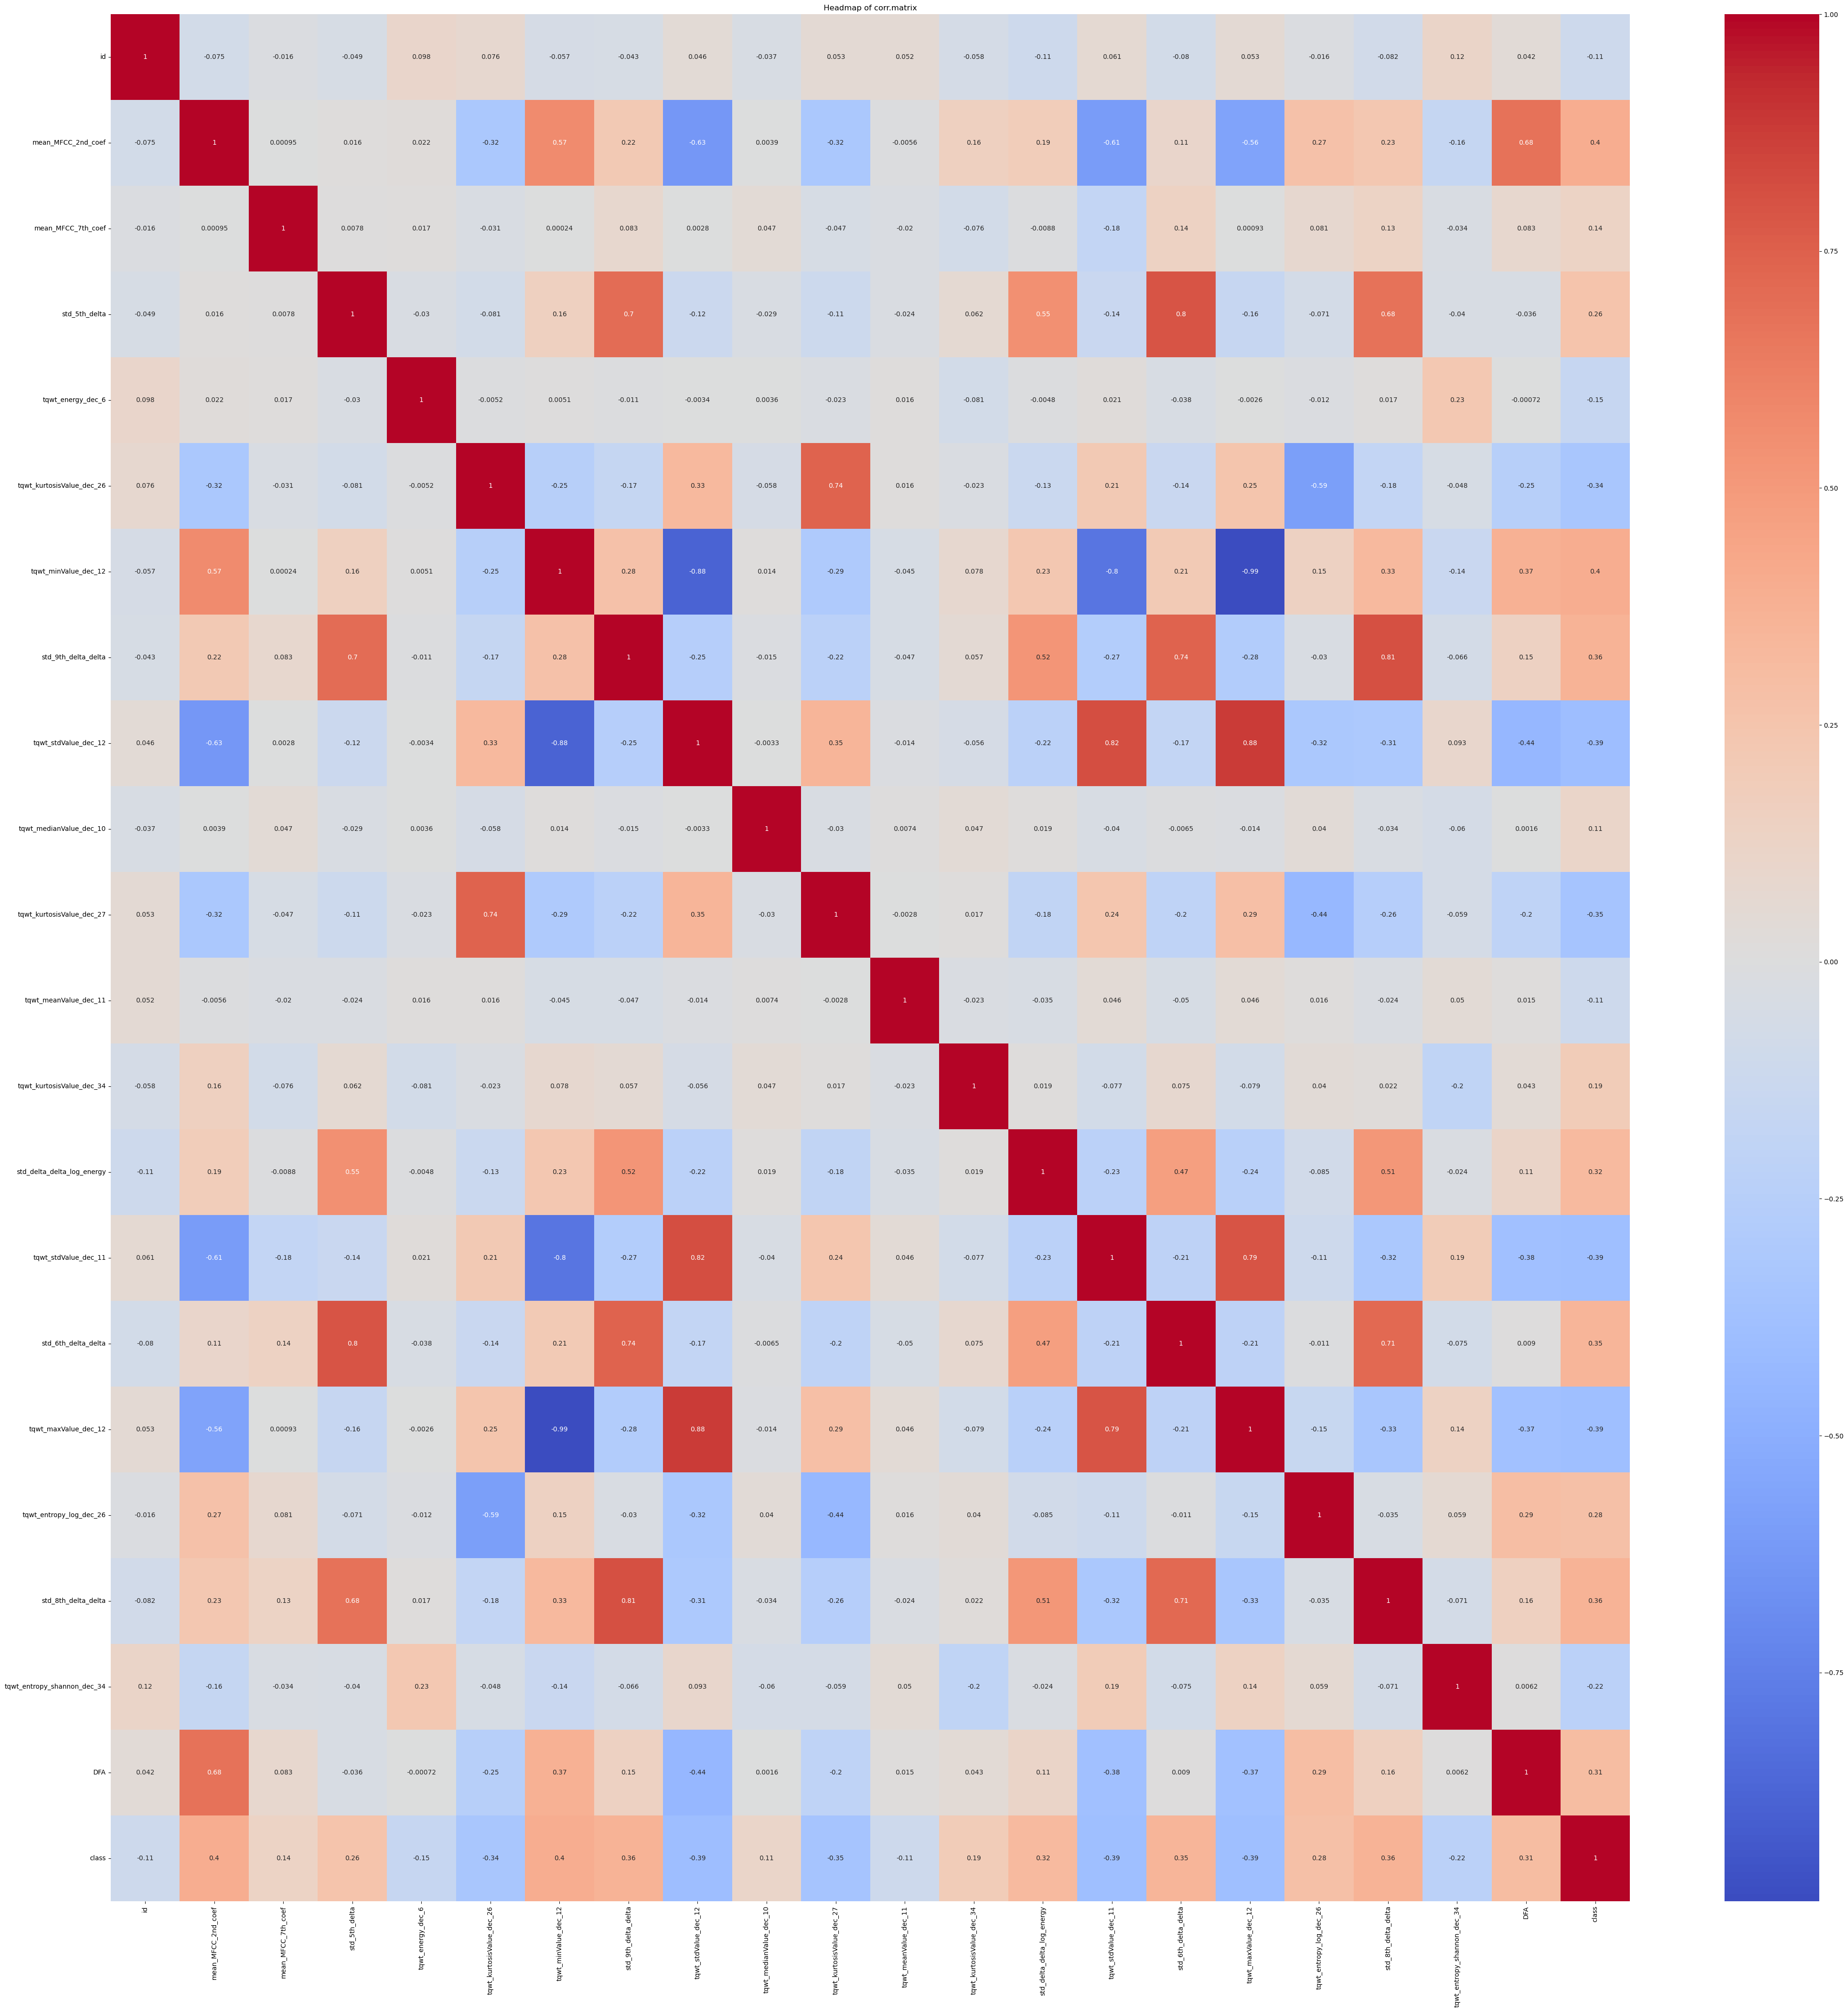

In [6]:
#Headmap of a correlation matrix for all selected variables
correlation_matrix = mrmr_data.corr()
plt.figure(figsize=(52,52))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Headmap of corr.matrix")
plt.show()

## Recursive Feature Elimination

In [7]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(class_weight="balanced", n_estimators=20, random_state=123, n_jobs=-1)

rfe = RFE(estimator, n_features_to_select=20)

selector = rfe.fit(X,y)

# Obtain selected features
rfe_features = selector.support_

# List of selected features
rfe_variable_names = X.columns[rfe_features].tolist()

In [8]:
rfe_X =pd.DataFrame(scaled_data[rfe_variable_names])
rfe_data = pd.concat([scaled_data.iloc[:,:1], rfe_X, scaled_data.iloc[:,754]], axis=1)

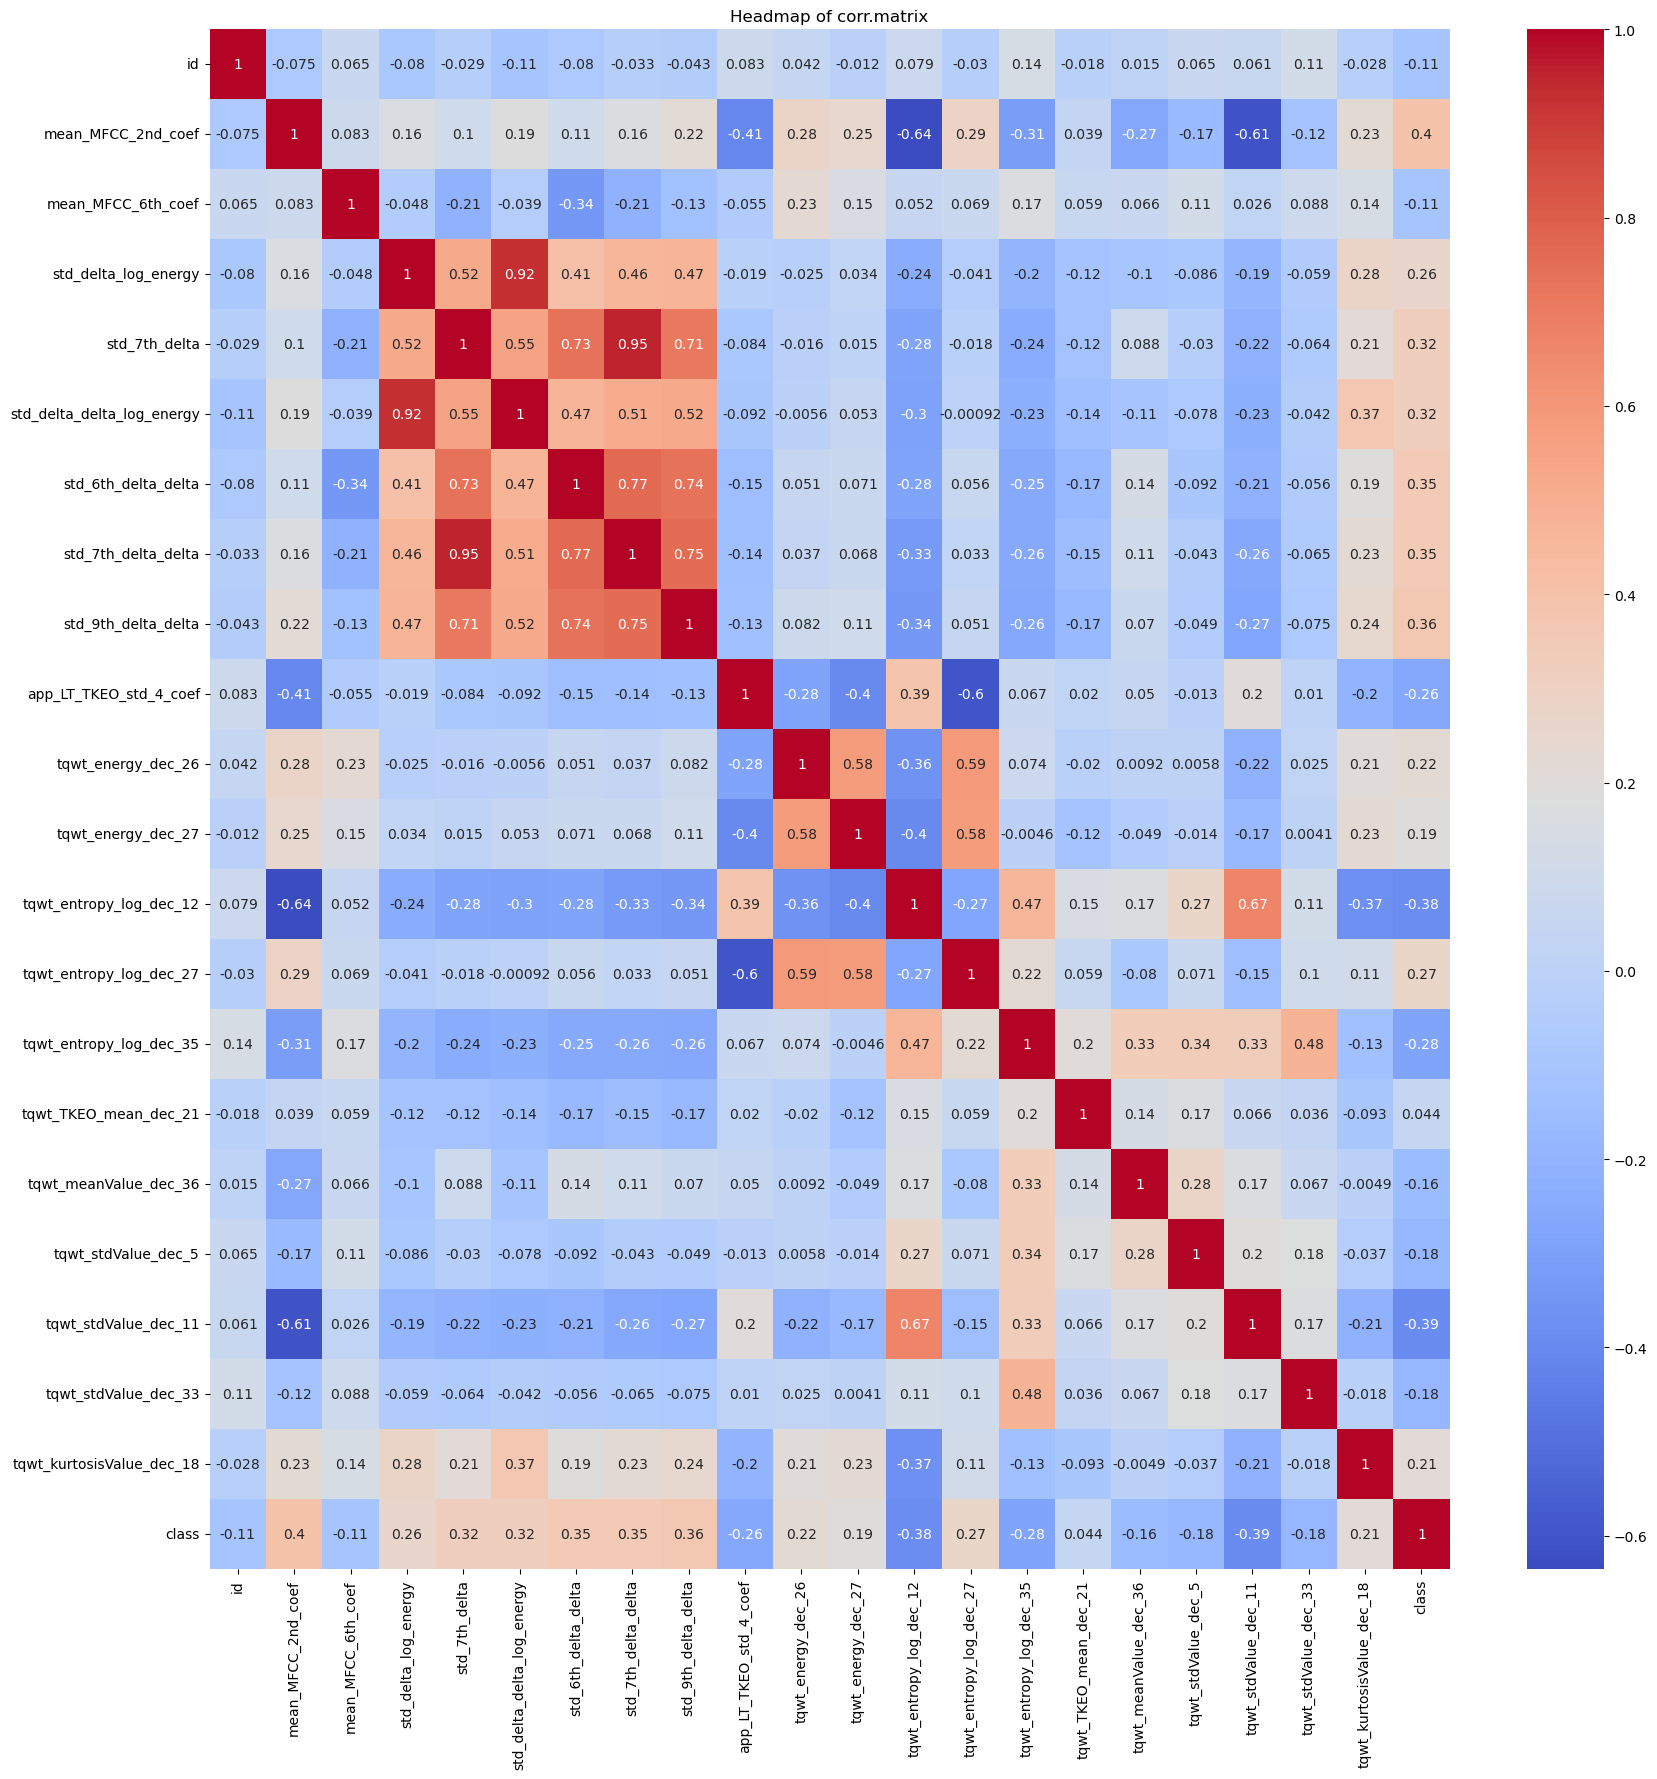

In [9]:
#Headmap of a correlation matrix for all selected variables
correlation_matrix = rfe_data.corr()
plt.figure(figsize=(len(rfe_variable_names),len(rfe_variable_names)))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Headmap of corr.matrix")
plt.show()

### Recursive Feature Elimination CV

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score


estimator = RandomForestClassifier(class_weight="balanced", n_estimators=20, random_state=123, n_jobs=-1)

# Cross-validation
sgkf = StratifiedGroupKFold(n_splits=10)

# RFECV
rfecv = RFECV(estimator, step=1, 
               cv=sgkf.split(X, y, groups=grup),
               scoring="matthews_corrcoef")


rfecv_sel = rfecv.fit(X,y)

In [11]:
# Selected features
rfecv_features = rfecv_sel.support_

# List of selected features
rfecv_variable_names = X.columns[rfecv_features].tolist()


In [12]:
# Obtenir els resultats de la validació creuada
cv_results_rfecv = rfecv.cv_results_

# Max MCC
mcc_max_rfecv = cv_results_rfecv['mean_test_score'].max()
index_max_mcc_rfecv = cv_results_rfecv['mean_test_score'].argmax() + 1  # +1 per a que coincideixi amb el nombre de característiques seleccionades

print("Max MCC:", mcc_max_rfecv)
print("Num selected features:", index_max_mcc_rfecv)


Max MCC: 0.5424329886049248
Num selected features: 21


In [13]:
rfecv_X =pd.DataFrame(scaled_data[rfecv_variable_names])
rfecv_data = pd.concat([scaled_data.iloc[:,:1], rfecv_X, scaled_data.iloc[:,754]], axis=1)

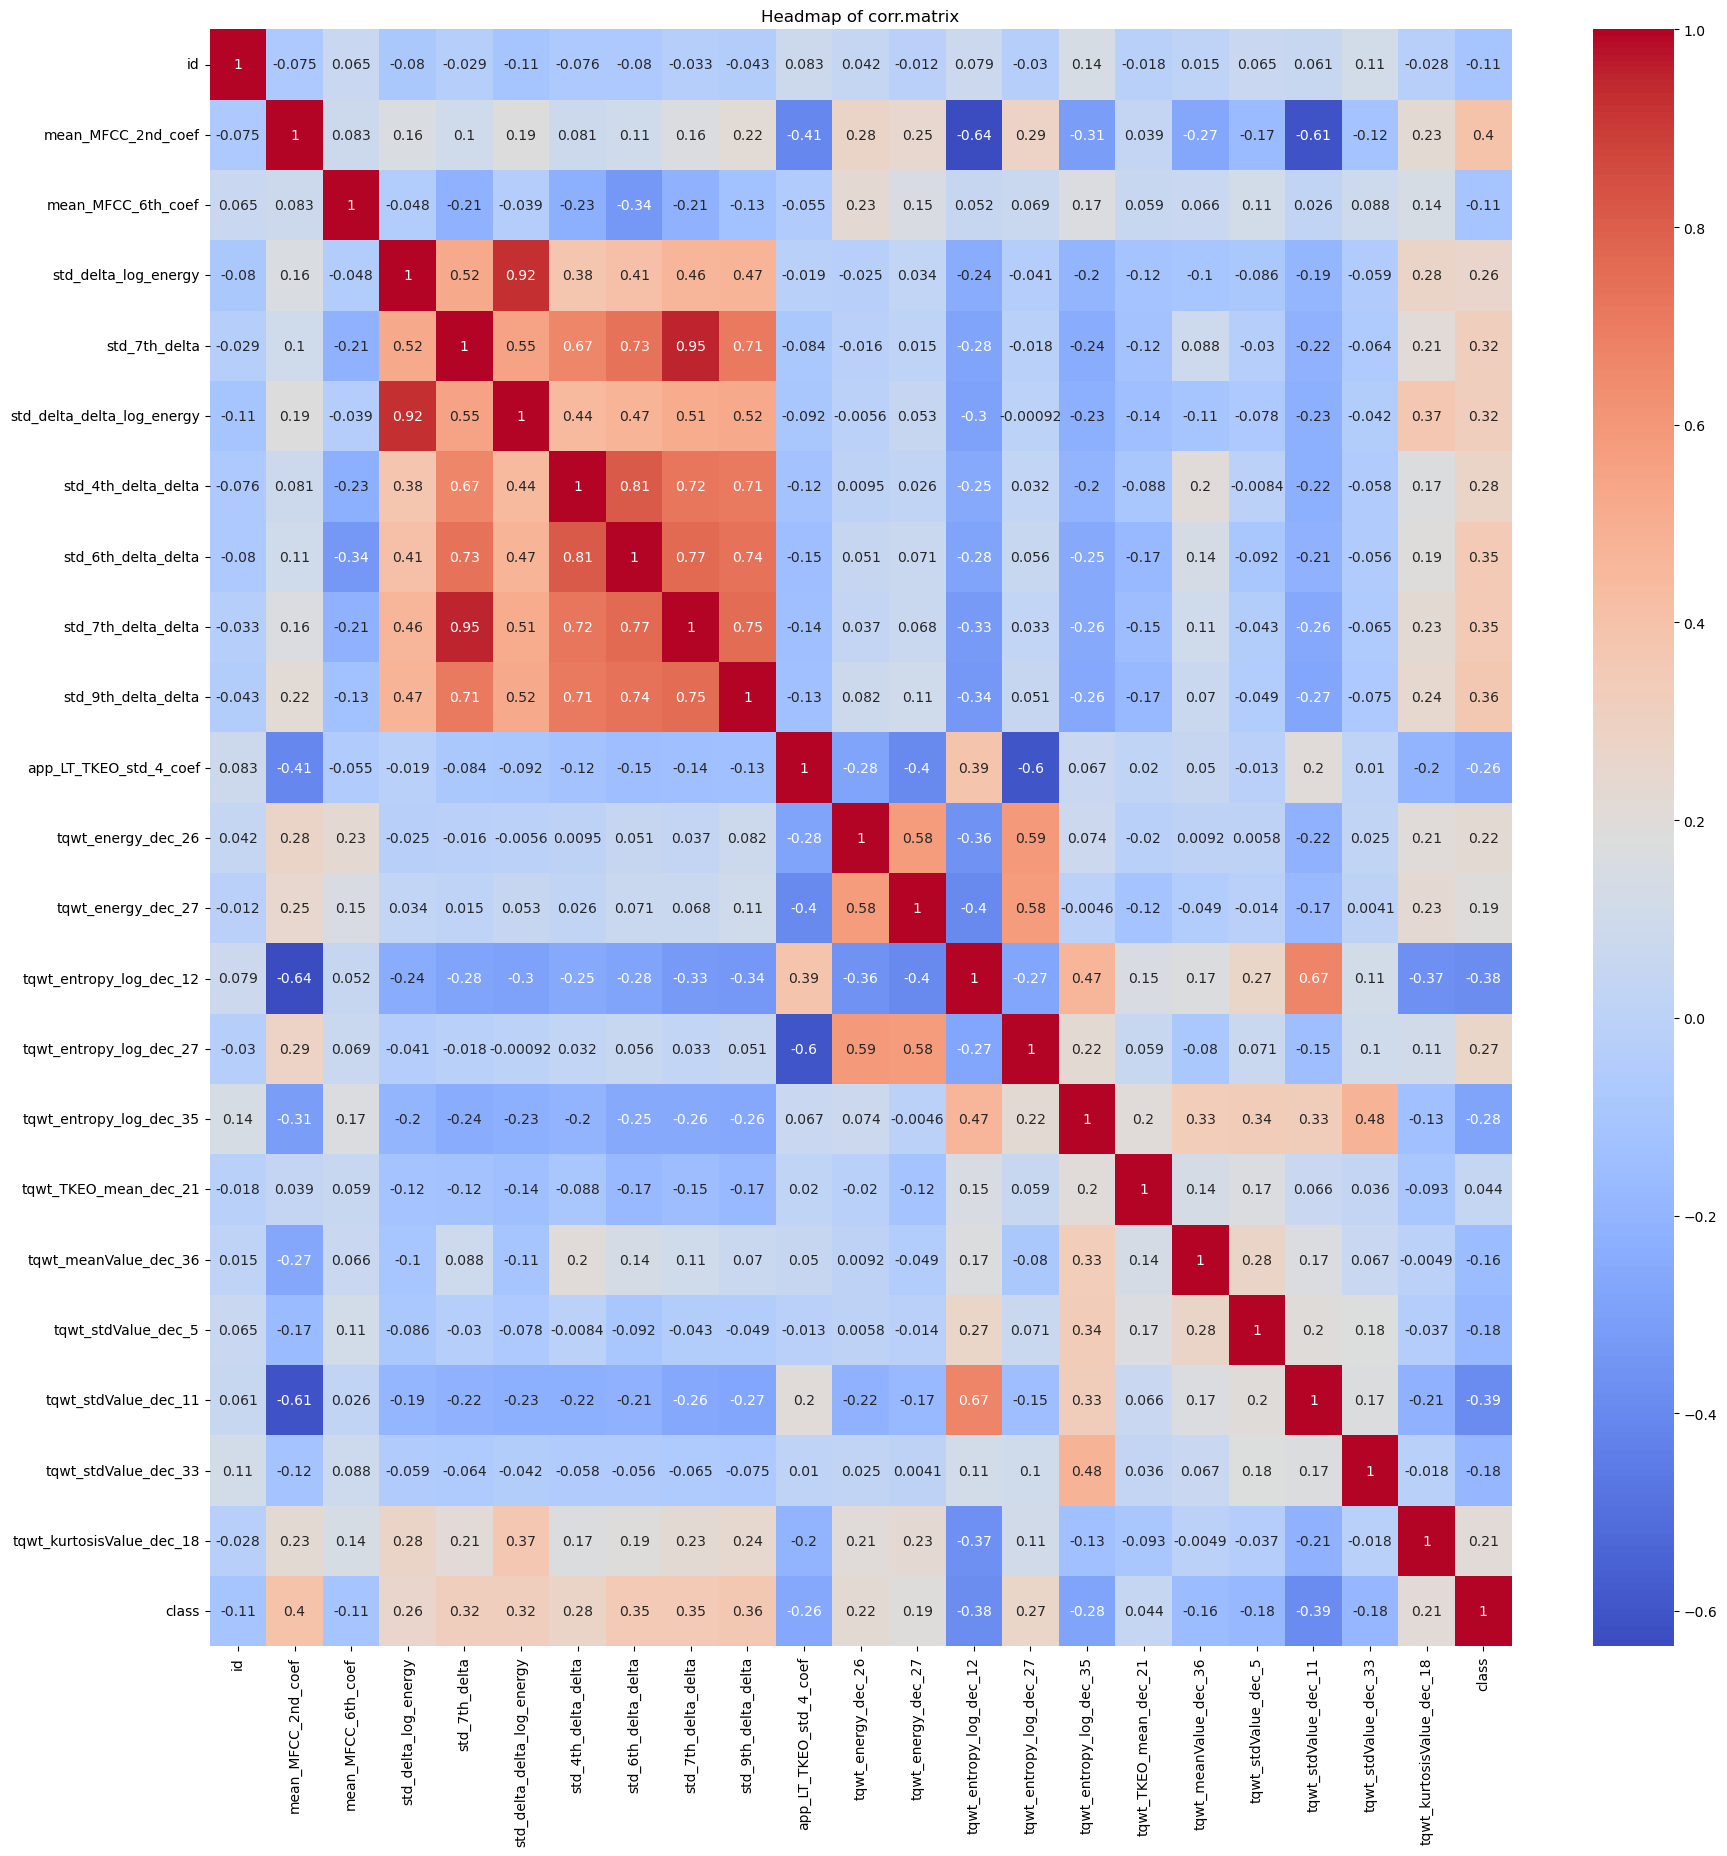

In [14]:
#Headmap of a correlation matrix for all selected variables
correlation_matrix = rfecv_data.corr()
plt.figure(figsize=(len(rfecv_variable_names),len(rfecv_variable_names)))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Headmap of corr.matrix")
plt.show()

## Genetic algorithm

In [15]:
import pygad
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import StratifiedGroupKFold

In [16]:
# Score according MCC 
def custom_score(y_true, y_pred):
    mcc = matthews_corrcoef(y_true, y_pred)
    return mcc

# Classifier
clf = RandomForestClassifier(class_weight="balanced", n_estimators=20, random_state=123, n_jobs=-1)

# Defineix la funció d'aptitud per a l'algorisme genètic
def fitness_func(ga_instance, solution, solution_idx):
    selected_features = np.where(solution == 1)[0]    # Selected features from 10 to 30 features
    if len(selected_features) < 10 or len(selected_features) > 30:
        return 0  

    # Subset of selected features
    X_selected = X.iloc[:, selected_features]
    
    # Cross-validation 
    sgkf = StratifiedGroupKFold(n_splits=10)  
    scores = cross_val_score(clf, X_selected, y, cv=sgkf.split(X_selected, y, groups=grup),
                             scoring=make_scorer(custom_score))
    return scores.mean()


# Custom initialization function: create individuals from 10 to 30 features
def custom_initialization(pop_size, num_genes, seed=123):
    np.random.seed(seed)
    population = np.zeros((pop_size, num_genes), dtype=int)
    for i in range(pop_size):
        num_selected = np.random.randint(10, 30)  
        selected_genes = np.random.choice(num_genes, num_selected, replace=False)  
        population[i, selected_genes] = 1
    return population


# Genetic algorithm
ga_instance = pygad.GA(
    num_generations = 20,  
    num_parents_mating = 20,
    fitness_func = fitness_func,
    sol_per_pop = 100,
    num_genes = X.shape[1],
    gene_space = [0, 1],  # Cada gen pot ser inclòs (1) o exclòs (0)
    parent_selection_type = "sss", # Stochastic Universal Sampling (Selecciona els individus segons la probabilitat proporcional de la seva fitness)
    keep_parents = 10,  # nombre de pares de la població anterior es mantenen a la nova generació
    crossover_type = "uniform",  #cada gen fill és seleccionat aleatòriament d'un dels pares
    mutation_type = "random",
    mutation_percent_genes = 10,
    initial_population=custom_initialization(100,X.shape[1])
)

ga_instance.run()

# Results
solution, solution_fitness, solution_idx = ga_instance.best_solution()
ga_selected_features = np.where(solution == 1)[0]
ga_selected_names = X.columns[ga_selected_features]

print("Best MCC:", solution_fitness)
len(ga_selected_names)


Best MCC: 0.47150956066721256


14

In [17]:
ga_X =pd.DataFrame(scaled_data[ga_selected_names])
ga_data = pd.concat([scaled_data.iloc[:,:1], ga_X, scaled_data.iloc[:,754]], axis=1)

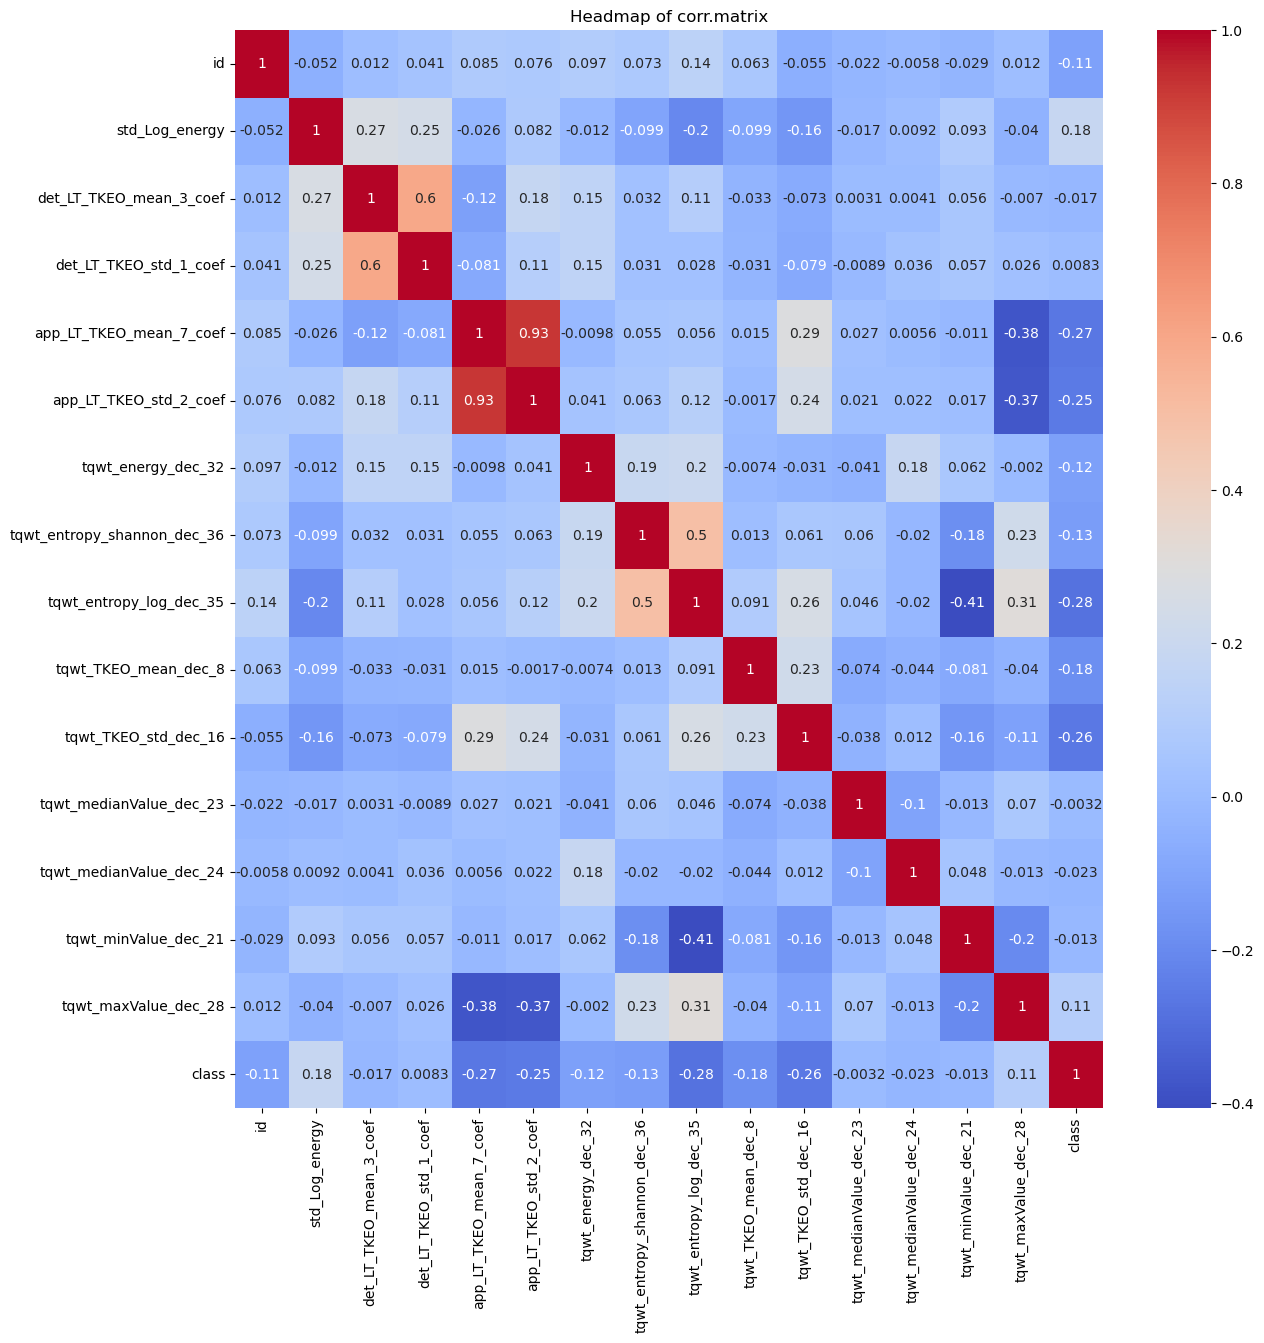

In [18]:
#Headmap of a correlation matrix for all selected variables
correlation_matrix = ga_data.corr()
plt.figure(figsize=(len(ga_selected_names),len(ga_selected_names)))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Headmap of corr.matrix")
plt.show()